### Wesley Janson and Drew Keller
## STAT 27420 Final Project
# Modeling Code

In [1]:
# Load in relevant packages

import pandas as pd
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from data_utils import read_data, prep_features, evaluate_predictions, rebin_outcome, summarize_predictions, evaluate_multilevel_predictions
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# set random seed for numpy
RANDOM_SEED=69
np.random.seed(RANDOM_SEED)


DATA_PATH = '../paper_replication_data/new_data.csv'  # Drew's path

In [2]:
from load_data import data, categorical_vars, cts_vars, other_vars

# loading data from online takes ~20 seconds
# to speed up, save data locally and load from there:

#data.to_csv(DATA_PATH,index=False)  # run this once

Excluding 2262 observations that did not answer 1 year price change question.


In [2]:
# Categorical_vars and cts_vars are lists of vars in each category.
# Other_vars are ID and date variables (categorical_vars + cts_vars + other_vars = all vars)

data = read_data(DATA_PATH)  # use this over pd.read_csv, because this handles types

In [3]:
data.treatment_bins.value_counts(dropna=False)  # check that we have a balanced dataset

0.0    185749
1.0     31599
NaN     18725
2.0      6010
3.0      2836
4.0      2368
Name: treatment_bins, dtype: int64

In [4]:
data.durable_purchase.value_counts(dropna=False)  # check that we have a balanced dataset

Good          171775
Bad            54240
Don't know     10247
Neutral         9243
Refused         1782
Name: durable_purchase, dtype: int64

***Regression***

In [3]:
# prep features for modeling; use regression=True for regression models
data_regression, treatment_vars, confounder_vars = prep_features(data,regression=True,missing_values='drop cts')  
X = data_regression[confounder_vars+["price_change_amt_next_yr"]]
Y = data_regression['durable_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

Excluding 12029 observations that refused or didn't know durable purchase question.
Excluding 70815 observations that did not answer confounder questions.
Excluding 9476 observations that did not answer price change amount question.


In [7]:
# Model 1a: ordered probit (same as Bachmann et al.) with cts treatment
mod_prob1a = OrderedModel(y_train,X_train,distr='probit')
res_prob1a = mod_prob1a.fit(method='bfgs')
res_prob1a.summary()

Optimization terminated successfully.
         Current function value: 0.613155
         Iterations: 142
         Function evaluations: 143
         Gradient evaluations: 143


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:       durable_purchase   Log-Likelihood:                -76015.
Model:                   OrderedModel   AIC:                         1.521e+05
Method:            Maximum Likelihood   BIC:                         1.524e+05
Date:                Sun, 04 Dec 2022                                         
Time:                        13:23:47                                         
No. Observations:              123973                                         
Df Residuals:                  123939                                         
Df Model:                          34                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
fed_funds_rate                           0.2239      0.006     38.545      0.000       0.212       0.235
unemployment_rate                       -0.1207      0.005    -24.452      0.000      -0.130      -0.111
cpi_1mo_lag                             -0.1546      0.006    -24.690      0.000      -0.167      -0.142
cpi_durable_1mo_lag                     -0.0829      0.006    -14.073      0.000      -0.094      -0.071
personal_finances_next_yr_Don't know    -0.1881      0.031     -5.980      0.000      -0.250      -0.126
personal_finances_next_yr_Refused       -0.2356      0.073     -3.247      0.001      -0.378      -0.093
personal_finances_next_yr_Same          -0.0602      0.009     -6.692      0.000      -0.078      -0.043
personal_finances_next_yr_Worse         -0.1900      0.014    -13.342      0.000      -0.218      -0.162
income_change_amt_next_yr               -0.0332      0.004     -7.873      0.000      -0.041      -0.025
conditions_next_yr_Don't know           -0.1513      0.038     -3.977      0.000      -0.226      -0.077
conditions_next_yr_Refused              -0.1890      0.075     -2.525      0.012      -0.336      -0.042
conditions_next_yr_Same                 -0.0375      0.010     -3.776      0.000      -0.057      -0.018
conditions_next_yr_Worse                -0.2332      0.013    -18.124      0.000      -0.258      -0.208
unemployment_next_yr_Higher             -0.2147      0.064     -3.355      0.001      -0.340      -0.089
unemployment_next_yr_Lower               0.0953      0.064      1.484      0.138      -0.031       0.221
unemployment_next_yr_Refused            -0.1105      0.130     -0.850      0.395      -0.365       0.144
unemployment_next_yr_Same                0.0483      0.064      0.756      0.450      -0.077       0.173
income_quintile_Lower middle            -0.0856      0.013     -6.447      0.000      -0.112      -0.060
income_quintile_Lowest                  -0.1610      0.015    -10.726      0.000      -0.190      -0.132
income_quintile_Middle                  -0.0656      0.012     -5.362      0.000      -0.090      -0.042
income_quintile_Upper middle            -0.0371      0.011     -3.240      0.001      -0.060      -0.015
age                                      0.0137      0.005      2.977      0.003       0.005       0.023
sex_Male                                 0.1023      0.008     12.604      0.000       0.086       0.118
education_Graduate school               -0.0273      0.012     -2.191      0.028      -0.052      -0.003
education_High school                    0.0167      0.012      1.429      0.153      -0.006       0.040
education_No high school                -0.2105      0.031     -6.824      0.000      -0.271      -0.150
education_Partial high school           -0.0260      0.022     -1.179      0.238      -0.069       0.017
education_So

In [8]:
y_test

54211    -1.0
12948     1.0
106443    1.0
179037    1.0
42451     0.0
         ... 
223908    1.0
75890     1.0
239600   -1.0
148680    1.0
37775     1.0
Name: durable_purchase, Length: 30994, dtype: float64

In [9]:
evaluate_predictions(res_prob1a, X_train, X_test, y_train, y_test, regression=True)

Baseline accuracy: 75.71%
Train accuracy: 75.91%
Test accuracy: 76.33%

Test predictions vs actual:


actual  predicted
-1.0    -1             746
         1            5845
 0.0    -1              27
         1             910
 1.0    -1             555
         1           22911
dtype: int64

In [10]:
X = data_regression[confounder_vars+treatment_vars]
Y = data_regression['durable_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

In [11]:
# Model 1b: ordered probit (same as Bachmann et al.) with cts treatment
mod_prob1b = OrderedModel(y_train,X_train,distr='probit')
res_prob1b = mod_prob1b.fit(method='bfgs')
res_prob1b.summary()

Optimization terminated successfully.
         Current function value: 0.613123
         Iterations: 153
         Function evaluations: 154
         Gradient evaluations: 154


/Users/drewkeller/opt/anaconda3/envs/stats/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:       durable_purchase   Log-Likelihood:                -76011.
Model:                   OrderedModel   AIC:                         1.521e+05
Method:            Maximum Likelihood   BIC:                         1.525e+05
Date:                Sun, 04 Dec 2022                                         
Time:                        13:26:43                                         
No. Observations:              123973                                         
Df Residuals:                  123935                                         
Df Model:                          38                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
fed_funds_rate                           0.2232        nan        nan        nan         nan         nan
unemployment_rate                       -0.1205        nan        nan        nan         nan         nan
cpi_1mo_lag                             -0.1548        nan        nan        nan         nan         nan
cpi_durable_1mo_lag                     -0.0831        nan        nan        nan         nan         nan
personal_finances_next_yr_Don't know    -0.1877        nan        nan        nan         nan         nan
personal_finances_next_yr_Refused       -0.2389        nan        nan        nan         nan         nan
personal_finances_next_yr_Same          -0.0610        nan        nan        nan         nan         nan
personal_finances_next_yr_Worse         -0.1904        nan        nan        nan         nan         nan
income_change_amt_next_yr               -0.0333        nan        nan        nan         nan         nan
conditions_next_yr_Don't know           -0.1510        nan        nan        nan         nan         nan
conditions_next_yr_Refused              -0.1895        nan        nan        nan         nan         nan
conditions_next_yr_Same                 -0.0381        nan        nan        nan         nan         nan
conditions_next_yr_Worse                -0.2334        nan        nan        nan         nan         nan
unemployment_next_yr_Higher             -0.2144        nan        nan        nan         nan         nan
unemployment_next_yr_Lower               0.0961        nan        nan        nan         nan         nan
unemployment_next_yr_Refused            -0.1104        nan        nan        nan         nan         nan
unemployment_next_yr_Same                0.0480        nan        nan        nan         nan         nan
income_quintile_Lower middle            -0.0858        nan        nan        nan         nan         nan
income_quintile_Lowest                  -0.1609        nan        nan        nan         nan         nan
income_quintile_Middle                  -0.0660        nan        nan        nan         nan         nan
income_quintile_Upper middle            -0.0372        nan        nan        nan         nan         nan
age                                      0.0140        nan        nan        nan         nan         nan
sex_Male                                 0.1034        nan        nan        nan         nan         nan
education_Graduate school               -0.0278        nan        nan        nan         nan         nan
education_High school                    0.0167        nan        nan        nan         nan         nan
education_No high school                -0.2118        nan        nan        nan         nan         nan
education_Partial high school           -0.0282        nan        nan        nan         nan         nan
education_So

In [12]:
evaluate_predictions(res_prob1b, X_train, X_test, y_train, y_test, regression=True)

Baseline accuracy: 75.71%
Train accuracy: 75.94%
Test accuracy: 76.31%

Test predictions vs actual:


actual  predicted
-1.0    -1             742
         1            5849
 0.0    -1              24
         1             913
 1.0    -1             555
         1           22911
dtype: int64

***Classification with XGBoost***

In [3]:
data_xgboost, treatment_vars, confounder_vars = prep_features(data,regression=False,missing_values='retain all')  

Excluding 12029 observations that refused or didn't know durable purchase question.
Excluding 16763 observations that did not answer price change amount question.


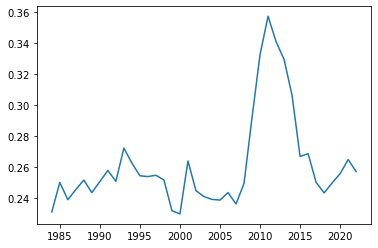

In [14]:
# only income_change_amt_next_yr has many missing values within our chosen cts confounders

# calculate percent missing for income_change_amt_next_yr by year 
pct_missing = data['income_change_amt_next_yr'].isnull().groupby(data.date.dt.year).agg(['mean','count'])
plt.plot(pct_missing["mean"])

In [15]:
# try dropping income_change_amt_next_yr
data_xgboost.drop(columns=['income_change_amt_next_yr'],inplace=True)  
confounder_vars.remove('income_change_amt_next_yr')

In [16]:
# Model 2: XGBoost with binned treatment

X = data_xgboost[confounder_vars+treatment_vars]
Y = data_xgboost['durable_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
model2 = xgb.XGBClassifier(learning_rate=0.07,max_depth=6,n_estimators=120,min_child_weight=3)
model2.fit(X_train, y_train)

/Users/drewkeller/opt/anaconda3/envs/stats/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=120, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
evaluate_predictions(model2, X_train, X_test, y_train, y_test)

Baseline accuracy: 73.88%
Train accuracy: 75.65%
Test accuracy: 74.93%

Test predictions vs actual:


actual  predicted
0       0             1502
        2             8278
1       0               91
        2             1544
2       0             1042
        2            31242
dtype: int64

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

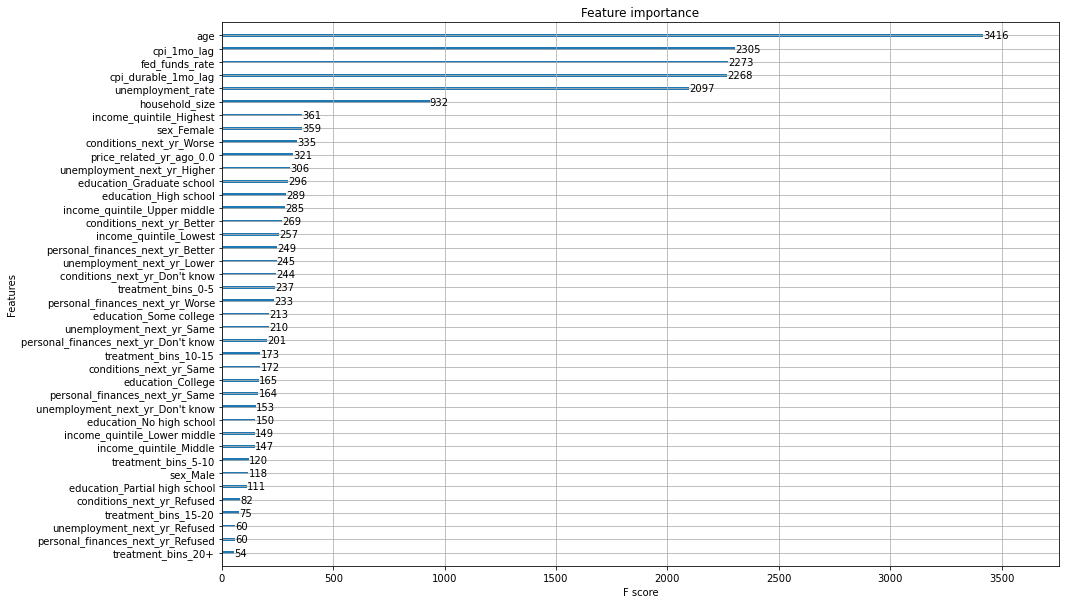

In [30]:
plt.rcParams['figure.figsize'] = [15, 10]
xgb.plot_importance(model2)

In [4]:
data_xgboost, treatment_vars, confounder_vars = prep_features(data,regression=False,missing_values='retain all')  

Excluding 12029 observations that refused or didn't know durable purchase question.
Excluding 16763 observations that did not answer price change amount question.


In [32]:
# try multiple classifiers

data_xgboost = rebin_outcome(data_xgboost)
X = data_xgboost[confounder_vars+treatment_vars]
Y = data_xgboost[['durable_purchase','durable_good','durable_bad']]
Xa, Xb, ya, yb = train_test_split(X, Y, test_size=0.5, random_state=7)  # just switch train and test
ya_good = ya['durable_good']
ya_bad = ya['durable_bad']
yb_good = yb['durable_good']
yb_bad = yb['durable_bad']

model3a = xgb.XGBClassifier(
    learning_rate=0.07,max_depth=4,n_estimators=120,min_child_weight=1,
    eval_metric='logloss',use_label_encoder=False)
model3a.fit(Xa, ya_good)

model3b = xgb.XGBClassifier(
    learning_rate=0.07,max_depth=4,n_estimators=120,min_child_weight=1,
    eval_metric='logloss',use_label_encoder=False)
model3b.fit(Xb, yb_bad)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.07, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=120, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [36]:
ya_pred = model3a.predict(Xb)
yb_pred = model3b.predict(Xa)
print(pd.DataFrame([ya_pred,yb_pred]).T.value_counts().to_dict())
print(yb_good.value_counts(normalize=True))
print(pd.Series(ya_pred).value_counts(normalize=True))
print(ya_bad.value_counts(normalize=True))
print(pd.Series(yb_pred).value_counts(normalize=True))

{(1.0, 0.0): 97091, (0.0, 0.0): 6595, (1.0, 1.0): 5183, (0.0, 1.0): 378}
1    0.73897
0    0.26103
Name: durable_good, dtype: float64
1    0.936173
0    0.063827
dtype: float64
0    0.77506
1    0.22494
Name: durable_bad, dtype: float64
0    0.949097
1    0.050903
dtype: float64


In [38]:
ya_pred = model3a.predict(Xa)
yb_pred = model3b.predict(Xb)
print(pd.DataFrame([ya_pred,yb_pred]).T.value_counts().to_dict())
print(ya_good.value_counts(normalize=True))
print(pd.Series(ya_pred).value_counts(normalize=True))
print(yb_bad.value_counts(normalize=True))
print(pd.Series(yb_pred).value_counts(normalize=True))

{(1.0, 0.0): 97016, (0.0, 0.0): 6681, (1.0, 1.0): 5154, (0.0, 1.0): 396}
1    0.737521
0    0.262479
Name: durable_good, dtype: float64
1    0.93522
0    0.06478
dtype: float64
0    0.775611
1    0.224389
Name: durable_bad, dtype: float64
0    0.949198
1    0.050802
dtype: float64


In [39]:
data_xgboost = rebin_outcome(data_xgboost)
X = data_xgboost[confounder_vars+treatment_vars]
Y = data_xgboost[['durable_purchase','durable_good','durable_bad']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
ya_train = y_train['durable_good']
yb_train = y_train['durable_bad']
ya_test = y_test['durable_good']
yb_test = y_test['durable_bad']

model3a = xgb.XGBClassifier(
    learning_rate=0.07,max_depth=4,n_estimators=120,min_child_weight=1,
    eval_metric='logloss',use_label_encoder=False)
model3a.fit(X_train, np.array(ya_train).astype(int))

model3b = xgb.XGBClassifier(
    learning_rate=0.05,max_depth=5,n_estimators=150,min_child_weight=3,
    eval_metric='logloss',use_label_encoder=False)
model3b.fit(X_train, np.array(yb_train).astype(int))

evaluate_multilevel_predictions(model3a, model3b, X_train, X_test, y_train, y_test)

Baseline accuracy: 73.88%
Train accuracy: 74.46%
Test accuracy: 74.17%

Test predictions vs actual:


actual  predicted
0       -1              37
         0            1247
         1             303
         2            8193
1       -1               1
         0              75
         1              31
         2            1528
2       -1              29
         0             809
         1             314
         2           31132
dtype: int64

***Classification with NN***

In [ ]:
# model 3: large neural network just to see if we can overfit at least
model3 = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=1000)
model3.fit(X_train, y_train)

In [ ]:
num_params = sum([coef.shape[0] * coef.shape[1] for coef in model3.coefs_])
num_params += sum([intercept.shape[0] for intercept in model3.intercepts_])
num_params

15603

In [ ]:
evaluate_predictions(model3, X_train, X_test, y_train, y_test,regression=False)

Baseline accuracy: 71.63%
Train accuracy: 76.52%
Test accuracy: 70.52%

Test predictions vs actual:


actual  predicted
0.0     0             3076
        1              109
        2             9738
1.0     0              307
        1               30
        2             1916
2.0     0             3495
        1              206
        2            34619
dtype: int64

***AIPW Estimation***

In [5]:
# Conditional outcome models (Q models)
def make_Q_model(model_type):
    ''' A function that returns a general ML q model for later use in k-folding'''
    if model_type == 'fast':
        return xgb.XGBClassifier(eval_metric = 'mlogloss'), 2
    else:
        return xgb.XGBClassifier(
            eval_metric = 'mlogloss',learning_rate=0.05,max_depth=5,n_estimators=150,min_child_weight=3), 5


# Propensity score models (g models)
def make_g_model(model_type):
    ''' A function that returns a g model for computing propensity scores'''
    if model_type == 'fast':
        return xgb.XGBClassifier(eval_metric = 'mlogloss'), 2
    else:
        return xgb.XGBClassifier(
            eval_metric = 'mlogloss',learning_rate=0.07,max_depth=6,n_estimators=120,min_child_weight=1), 5

In [6]:
# Functions for K-fold cross-fitting
def treatment_k_fold_fit_and_predict(X:pd.DataFrame, A:np.array, model_type='slow'):
    '''
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    '''

    make_model, n_splits = make_g_model(model_type)

    predictions = np.empty((len(X),5), dtype=float)  # row per obs, col per treatment bin
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    kf.split(X, A)
    for train_index, test_index in kf.split(X, A):
        X_train = X.iloc[train_index]
        A_train = A.iloc[train_index]
        g = make_model
        g.fit(X_train, A_train)
        
        # get predictions for split
        predictions[test_index] = g.predict_proba(X.iloc[test_index])
    
    # sanity check that overlap holds
    assert np.isnan(predictions).sum() == 0

    return predictions, g


def conditionalize_on_column(g,col_index=0):
    divisors = g+g[:,col_index][:,np.newaxis]
    g_cond = g / divisors
    g_cond[:,col_index] = 1  # won't use, but for completeness
    return g_cond


def outcome_k_fold_fit_and_predict(
    X:pd.DataFrame, y:np.array, A:pd.DataFrame, model_type='slow', output_type='categorical'):
    '''
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    output_type: type of outcome, "categorical" or "continuous"
    '''

    make_model, n_splits = make_Q_model(model_type)

    # initialize: row per obs, col per outcome
    predictions0 = np.empty((len(X),3), dtype=float)
    predictions1 = np.empty((len(X),3), dtype=float)
    predictions2 = np.empty((len(X),3), dtype=float)
    predictions3 = np.empty((len(X),3), dtype=float)
    predictions4 = np.empty((len(X),3), dtype=float)

    if output_type == 'categorical':
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # for predicting effect under treatment / control status for each data point 
    X_w_treatment = pd.concat(
        [X, pd.DataFrame(0, columns=A.columns,index=A.index)], axis=1)
    X0 = X_w_treatment.copy()
    X0["treatment_bins_0.0"] = 1
    X1 = X_w_treatment.copy()
    X1["treatment_bins_1.0"] = 1
    X2 = X_w_treatment.copy()
    X2["treatment_bins_2.0"] = 1
    X3 = X_w_treatment.copy()
    X3["treatment_bins_3.0"] = 1
    X4 = X_w_treatment.copy()
    X4["treatment_bins_4.0"] = 1

    # include the treatment as input feature
    X_w_treatment = pd.concat([X, A], axis=1)

    for train_index, test_index in kf.split(X_w_treatment, np.transpose(y)):
        X_train = X_w_treatment.iloc[train_index]
        y_train = y.iloc[train_index]
        q = make_model
        q.fit(X_train, y_train)

        if output_type =='categorical':
            predictions0[test_index,:] = q.predict_proba(X0.iloc[test_index])
            predictions1[test_index,:] = q.predict_proba(X1.iloc[test_index])
            predictions2[test_index,:] = q.predict_proba(X2.iloc[test_index])
            predictions3[test_index,:] = q.predict_proba(X3.iloc[test_index])
            predictions4[test_index,:] = q.predict_proba(X4.iloc[test_index])
        elif output_type == 'continuous':
            predictions0[test_index,:] = q.predict(X0.iloc[test_index])
            predictions1[test_index,:] = q.predict(X1.iloc[test_index])

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1, predictions2, predictions3, predictions4, q


def ate_aiptw(Q_control, Q_treat, g, A, Y, prob_t=None):
    """Double ML estimator for the ATE
    Return: aiptw of ATE and its standard error"""

    # number of observations
    n = Y.shape[0]

    # ate aiptw"
    tau_hat = (Q_treat - Q_control + A*(Y-Q_treat)/g - (1-A)*(Y-Q_control)/(1-g)).mean()
    
    # influence curve and standard error of aiptw
    phi = Q_treat - Q_control + A*(Y-Q_treat)/g - (1-A)*(Y-Q_control)/(1-g) - tau_hat
    std_hat = np.std(phi) / np.sqrt(n)
    
    return tau_hat, std_hat

In [7]:
data_xgboost, treatment_vars, confounder_vars = prep_features(data,regression=False,missing_values='retain all')  

Excluding 12029 observations that refused or didn't know durable purchase question.
Excluding 16763 observations that did not answer price change amount question.


In [8]:
# Fit Q(A,X) model
# get conditional outcomes
Q0, Q1, Q2, Q3, Q4, q_importance = outcome_k_fold_fit_and_predict(
    X=data_xgboost[confounder_vars], y=data_xgboost["durable_purchase"], A=data_xgboost[treatment_vars[:-1]])

In [10]:
# Fit g(x) model
g, g_importance = treatment_k_fold_fit_and_predict(X=data_xgboost[confounder_vars], A=data_xgboost["treatment_bins"])

In [50]:
g_cond = conditionalize_on_column(g)

In [51]:
# Let's do a table of effects! 

outcomes = ['durable_purchase_0','durable_purchase_1','durable_purchase_2']
treatments = treatment_vars[1:-1]

estimates = pd.DataFrame(columns={'outcome':'','treatment':'','ATE':0.0,'std':0.0})
for outcome in outcomes:
    for treatment in treatments:
        data_and_nuisance_estimates_xgb = pd.DataFrame(
            {'g': g_cond[:,int(treatment[-3])], 'Q_control': Q0[:,int(outcome[-1])], 'Q_treat': Q1[:,int(outcome[-1])],
            'A': data_xgboost[treatment], 'Y': data_xgboost[outcome]})
        tau_hat, std_hat = ate_aiptw(**data_and_nuisance_estimates_xgb)
        #estimates.loc[estimates['outcome']=='',:] = [outcome,treatment,tau_hat,std_hat]
        estimates = estimates.append({
            'outcome':outcome,'treatment':treatment,'ATE':round(tau_hat,4),'std':round(std_hat,4)},
            ignore_index=True)

# calculate p-values (two-tailed)
estimates['p-value'] = 2*(norm.sf(abs(estimates['ATE']/estimates['std'])))
estimates['95% significant'] = np.where(abs(estimates['ATE']) > 1.96*estimates['std'], 'Yes', 'No')

estimates.replace(to_replace={
    'durable_purchase_0':'Negative',
    'durable_purchase_1':'Neutral',
    'durable_purchase_2':'Positive',
    'treatment_bins_1.0':'5-10% inflation',
    'treatment_bins_2.0':'10-15% inflation',
    'treatment_bins_3.0':'15-20% inflation',
    'treatment_bins_4.0':'20+% inflation'},
    inplace=True)

estimates

,outcome,treatment,ATE,std,p-value,95% significant
0,Negative,5-10% inflation,0.0221,0.0028,2.953456e-15,Yes
1,Negative,10-15% inflation,0.0413,0.0058,1.073884e-12,Yes
2,Negative,15-20% inflation,0.0411,0.0078,1.369966e-07,Yes
3,Negative,20+% inflation,0.0234,0.0056,2.933459e-05,Yes
4,Neutral,5-10% inflation,0.0032,0.0014,2.227098e-02,Yes
5,Neutral,10-15% inflation,0.0003,0.0024,9.005236e-01,No
6,Neutral,15-20% inflation,0.0006,0.0030,8.414806e-01,No
7,Neutral,20+% inflation,0.0031,0.0024,1.964726e-01,No
8,Positive,5-10% inflation,-0.0253,0.0030,3.359560e-17,Yes
9,Positive,10-15% inflation,-0.0416,0.0060,4.110381e-12,Yes


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

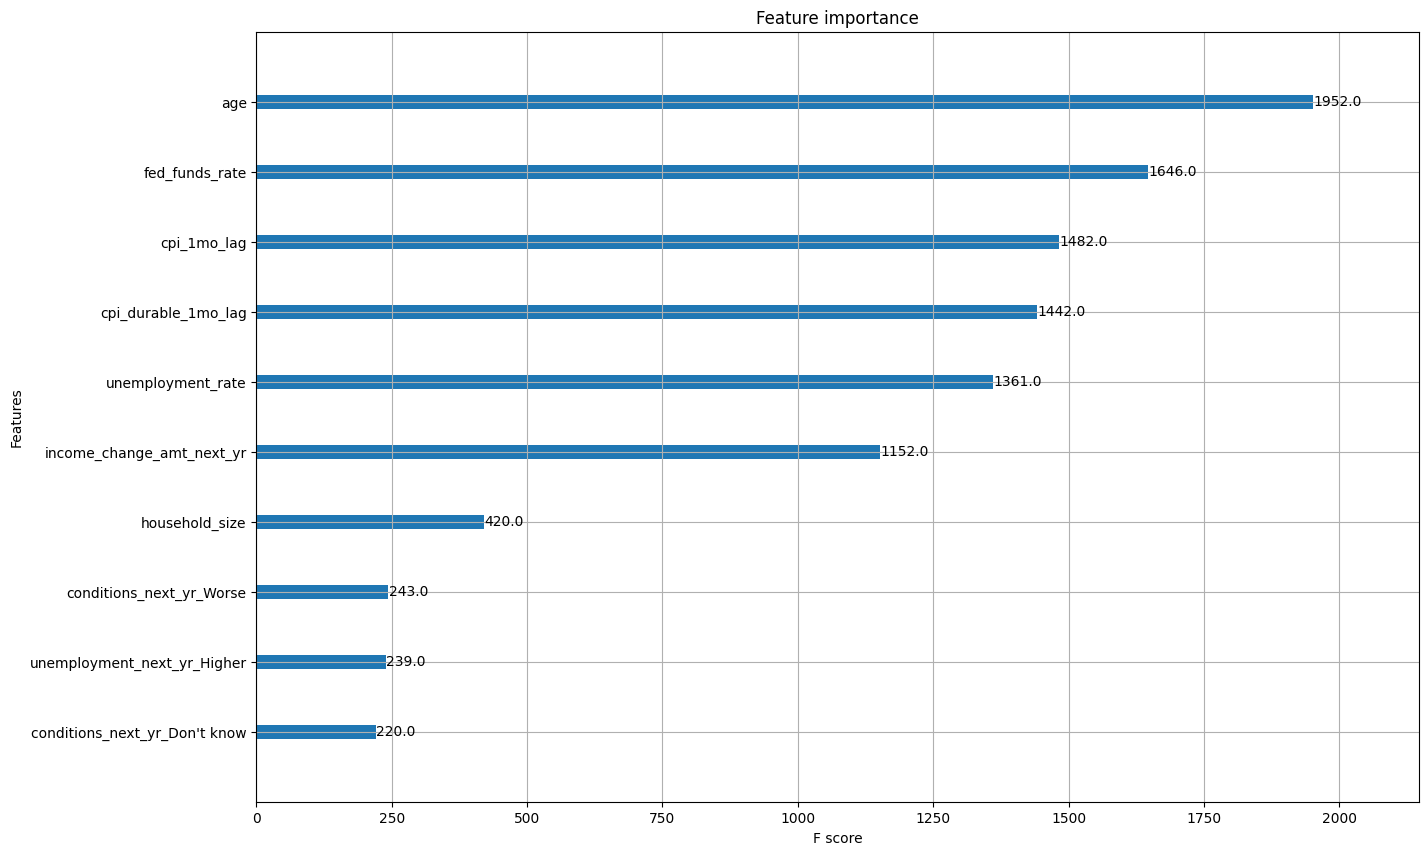

In [28]:
# Plotting Q model importance
plt.rcParams['figure.figsize'] = [15, 10]
xgb.plot_importance(q_importance, max_num_features=10)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

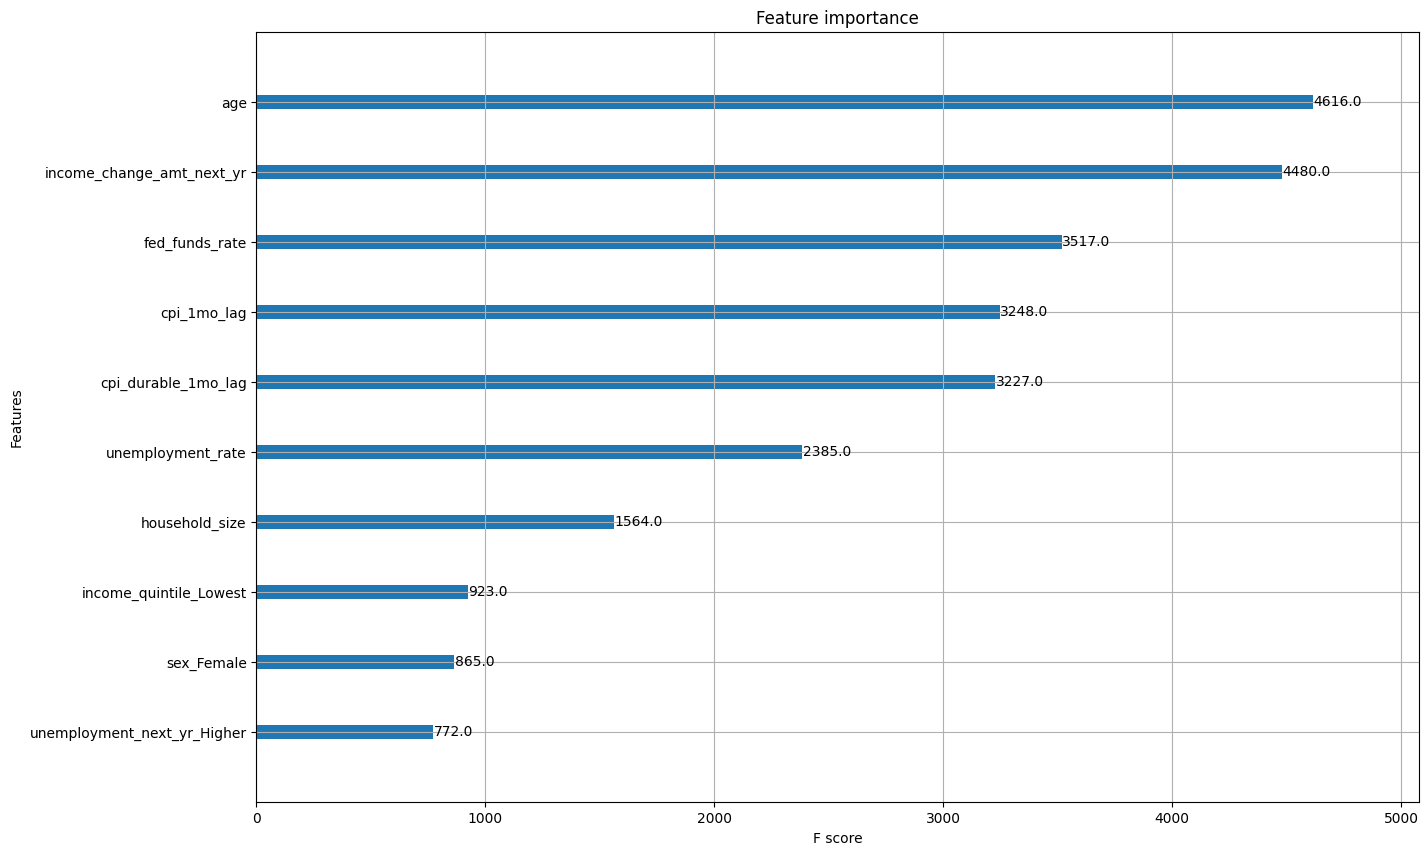

In [27]:
# Plotting g model importance
plt.rcParams['figure.figsize'] = [15, 10]
xgb.plot_importance(g_importance, max_num_features=10)

_Some old stuff keeping just in case for now - delete later_

In [ ]:
# Need to select the desired column of the Q predictions! ie one of {0,1,2}
# Need to select the desired column of the g_cond predictions! ie one of {1,2,3,4} (don't use 0! it's untreated)

# AIPW for Good for 5-10% inflation predictors compared to 0-5%
data_and_nuisance_estimates_xgb = pd.DataFrame(
    {'g': g_cond[:,1], 'Q_control': Q0[:,2], 'Q_treat': Q1[:,2],
    'A': data_xgboost["treatment_bins_1.0"], 'Y': data_xgboost["durable_purchase_2"]})
tau_hat, std_hat = ate_aiptw(**data_and_nuisance_estimates_xgb)
print(f"The ATE AIPTW is {tau_hat} with a std = {std_hat}")

# Pre-Wesley's changes 12/6: The ATE AIPTW is 0.5910816442549504 with a std = 0.015243537827750696

In [17]:
# Probably need to conditionalize the Q predictions too??
# 12/6 update: probably not actually

# AIPW for Good for 10-15% inflation predictors compared to 0-5%, Q conditional
q0_cond = conditionalize_on_column(Q0)
q1_cond = conditionalize_on_column(Q1)
data_and_nuisance_estimates_xgb = pd.DataFrame(
    {'g': g_cond[:,1], 'Q_control': q0_cond[:,2], 'Q_treat': q1_cond[:,2],
    'A': data_xgboost["treatment_bins_1.0"], 'Y': data_xgboost["durable_purchase_2"]})
tau_hat, std_hat = ate_aiptw(**data_and_nuisance_estimates_xgb)
print(f"The ATE AIPTW is {tau_hat} with a std = {std_hat}")


The ATE AIPTW is -0.0256634274986595 with a std = 0.0036139236682537173


In [10]:
# old - this won't work anymore

data_and_nuisance_estimates_xgb = pd.DataFrame(
    {'g': g, 'Q_control': Q0_lm, 'Q_treat': Q1_lm, 'A': data_xgboost["treatment_bins"], 'Y': data_xgboost["durable_purchase"]})

# AIPW for 5-10% inflation predictors compared to 0-5%
tau_hat, std_hat = ate_aiptw(**data_and_nuisance_estimates_xgb)
print(f"The ATE AIPTW is {tau_hat} with a std = {std_hat}")

The ATE AIPTW is 1.272947023869124 with a std = 0.021873424846318285
